In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.animation as animation
import pandas as pd
import datetime
import seaborn as sns
import os

In [2]:
energy_path = "./data/france_production.csv"
weather_path = "./data/france_weather.csv"
output_path = "./output"

In [3]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
try:
    weather_df = pd.read_csv(weather_path)
    energy_df = pd.read_csv(energy_path)
except FileNotFoundError:
    print("./data/france_production.csv or ./data/france_weather.csv not found")
    exit(1)

In [5]:
energy_df.columns

Index(['Date and Hour', 'Date', 'StartHour', 'EndHour', 'Source', 'Production',
       'dayOfYear', 'dayName', 'monthName'],
      dtype='object')

In [6]:
energy_df.head()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


In [7]:
energy_df["Date and Hour"] = pd.to_datetime(energy_df["Date and Hour"], utc=True)
weather_df["dt_iso"] = weather_df["dt_iso"].map(lambda x: x.replace(" UTC", ""))
weather_df["dt_iso"] = pd.to_datetime(weather_df["dt_iso"])

In [8]:
energy_df["StartHour"] = energy_df["StartHour"].astype(str)
energy_df["EndHour"] = energy_df["EndHour"].astype(str)
energy_df["StartHour"] = energy_df["StartHour"].map(lambda x: x.replace(":", ""))
energy_df["EndHour"] = energy_df["EndHour"].map(lambda x: x.replace(":", ""))
energy_df["StartHour"] = energy_df["StartHour"].astype(int)
energy_df["EndHour"] = energy_df["EndHour"].astype(int)
diff = energy_df["EndHour"] - energy_df["StartHour"]
print(diff.value_counts())
print(energy_df.shape)

10000    59806
Name: count, dtype: int64
(59806, 9)


all the differences are 1, so we can drop Date, StartHour, EndHour, dayOfYear, dayName, monthName and use only "Date and Hour" column

In [9]:
energy_df.drop(
    columns=["Date", "StartHour", "EndHour", "dayOfYear", "dayName", "monthName"],
    inplace=True,
)
energy_df.rename(
    columns={
        "Date and Hour": "dt_iso",
        "Production": "production",
        "Source": "source",
    },
    inplace=True,
)
energy_df.head()

,dt_iso,source,production
0,2020-07-22 18:00:00+00:00,Solar,244.0
1,2020-07-23 05:00:00+00:00,Solar,223.0
2,2020-07-23 14:00:00+00:00,Solar,2517.0
3,2020-07-23 17:00:00+00:00,Solar,658.0
4,2020-07-23 21:00:00+00:00,Solar,0.0


In [10]:
energy_df.isna().sum()
display(energy_df[energy_df["production"].isna()])

,dt_iso,source,production
36164,2022-03-27 01:00:00+00:00,Solar,NaN
39321,2022-03-27 01:00:00+00:00,Wind,NaN


only 2 rows, we can drop them

In [11]:
energy_df.dropna(inplace=True)

In [12]:
weather_df.columns

Index(['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'temp',
       'visibility', 'dew_point', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed',
       'wind_deg', 'wind_gust', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

In [13]:
weather_df.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1595376000,2020-07-22 00:00:00+00:00,7200,France,46.227638,2.213749,17.31,NaN,13.83,17.19,...,NaN,2.05,NaN,NaN,NaN,99,501,Rain,moderate rain,10n
1,1595379600,2020-07-22 01:00:00+00:00,7200,France,46.227638,2.213749,16.65,NaN,13.00,16.43,...,NaN,0.39,NaN,NaN,NaN,77,500,Rain,light rain,10n
2,1595383200,2020-07-22 02:00:00+00:00,7200,France,46.227638,2.213749,15.85,NaN,12.22,15.55,...,NaN,NaN,NaN,NaN,NaN,24,801,Clouds,few clouds,02n
3,1595386800,2020-07-22 03:00:00+00:00,7200,France,46.227638,2.213749,15.05,NaN,12.19,14.78,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
4,1595390400,2020-07-22 04:00:00+00:00,7200,France,46.227638,2.213749,13.95,NaN,11.82,13.67,...,NaN,NaN,NaN,NaN,NaN,5,800,Clear,sky is clear,01n


In [14]:
print(weather_df.shape)

(25776, 28)


In [15]:
print(weather_df.isna().sum())

dt                         0
dt_iso                     0
timezone                   0
city_name                  0
lat                        0
lon                        0
temp                       0
visibility             25776
dew_point                  0
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
sea_level              25776
grnd_level             25776
humidity                   0
wind_speed                 0
wind_deg                   0
wind_gust              25776
rain_1h                21914
rain_3h                25776
snow_1h                25571
snow_3h                25776
clouds_all                 0
weather_id                 0
weather_main               0
weather_description        0
weather_icon               0
dtype: int64


we can drop all columns that are empty and also the ones that are not useful for analysis

In [16]:
weather_df.drop(
    columns=[
        "dt",
        "timezone",
        "city_name",
        "lat",
        "lon",
        "visibility",
        "sea_level",
        "grnd_level",
        "wind_gust",
        "rain_3h",
        "snow_3h",
        "weather_id",
        "weather_description",
        "weather_main",
        "weather_icon",
    ],
    inplace=True,
)

In [17]:
print(weather_df.isna().sum())

dt_iso            0
temp              0
dew_point         0
feels_like        0
temp_min          0
temp_max          0
pressure          0
humidity          0
wind_speed        0
wind_deg          0
rain_1h       21914
snow_1h       25571
clouds_all        0
dtype: int64


In [18]:
display(weather_df[[not x for x in weather_df["rain_1h"].isna()]].head())

,dt_iso,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,clouds_all
0,2020-07-22 00:00:00+00:00,17.31,13.83,17.19,16.45,18.44,1021,80,1.42,20,2.05,NaN,99
1,2020-07-22 01:00:00+00:00,16.65,13.00,16.43,15.89,17.89,1021,79,0.67,35,0.39,NaN,77
96,2020-07-26 00:00:00+00:00,17.38,12.91,17.13,16.45,17.89,1014,75,2.61,219,0.19,NaN,88
105,2020-07-26 09:00:00+00:00,19.82,15.26,19.82,19.22,20.11,1017,75,5.04,245,0.29,NaN,77
106,2020-07-26 10:00:00+00:00,21.10,16.08,21.17,20.57,21.86,1017,73,3.79,240,0.40,NaN,78


In [19]:
display(weather_df[[not x for x in weather_df["snow_1h"].isna()]].head())

,dt_iso,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,clouds_all
3295,2020-12-06 07:00:00+00:00,0.89,0.04,-3.15,0.11,0.89,998,94,3.94,195,NaN,0.13,98
3387,2020-12-10 03:00:00+00:00,1.67,0.81,-2.34,1.22,1.76,1005,94,4.17,182,NaN,0.24,100
3744,2020-12-25 00:00:00+00:00,1.75,0.89,-2.42,0.67,2.00,1024,94,4.46,331,NaN,0.15,61
3745,2020-12-25 01:00:00+00:00,1.47,1.05,-2.95,0.67,2.00,1024,97,4.77,332,NaN,0.14,76
3746,2020-12-25 02:00:00+00:00,1.10,0.82,-3.36,0.67,1.45,1024,98,4.68,331,NaN,0.22,98


In [20]:
weather_df["rain_1h"].fillna(0, inplace=True)
weather_df["snow_1h"].fillna(0, inplace=True)

In [21]:
print(weather_df.isna().sum())

dt_iso        0
temp          0
dew_point     0
feels_like    0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
snow_1h       0
clouds_all    0
dtype: int64


In [22]:
print(weather_df.shape)
print(energy_df.shape)

(25776, 13)
(59804, 3)


peculiarity of the datasets, the energy dataset has more than double the rows of the weather dataset.

In [23]:
energy_df.sort_values(by="dt_iso", inplace=True)
display(energy_df)

,dt_iso,source,production
613,2019-12-31 23:00:00+00:00,Solar,0.0
172,2019-12-31 23:00:00+00:00,Wind,3549.0
11231,2020-01-01 00:00:00+00:00,Wind,2952.0
616,2020-01-01 00:00:00+00:00,Solar,0.0
9597,2020-01-01 01:00:00+00:00,Wind,2722.0
...,...,...,...
58948,2023-06-30 19:00:00+00:00,Wind,4857.0
59521,2023-06-30 20:00:00+00:00,Solar,1.0
58950,2023-06-30 20:00:00+00:00,Wind,5140.0
58947,2023-06-30 21:00:00+00:00,Wind,6135.0


we have been bamboozled. The energy dataset was not originally sorted, so the
purchase of the weather dataset does not cover all the covered period of the
energy dataset. We will have to drop the rows that are not covered by the
weather dataset.

In [24]:
energy_df = energy_df[energy_df["dt_iso"].isin(weather_df["dt_iso"])]

In [25]:
print(energy_df.shape)
print(weather_df.shape)

(51544, 3)
(25776, 13)


In [26]:
energy_df["dt_iso"].value_counts().sort_values(ascending=False)

dt_iso
2021-10-31 01:00:00+00:00    3
2020-10-25 01:00:00+00:00    3
2021-07-14 19:00:00+00:00    2
2020-07-22 17:00:00+00:00    2
2020-07-22 07:00:00+00:00    2
                            ..
2023-06-30 19:00:00+00:00    2
2023-06-30 20:00:00+00:00    2
2023-06-29 23:00:00+00:00    2
2023-06-29 22:00:00+00:00    2
2023-06-30 21:00:00+00:00    2
Name: count, Length: 25771, dtype: int64

In [27]:
display(energy_df[energy_df["dt_iso"] == "2021-10-31 01:00:00+00:00"])
display(energy_df[energy_df["dt_iso"] == "2020-10-25 01:00:00+00:00"])

,dt_iso,source,production
29124,2021-10-31 01:00:00+00:00,Wind,4379.0
30669,2021-10-31 01:00:00+00:00,Solar,2.0
30433,2021-10-31 01:00:00+00:00,Wind,4698.0


,dt_iso,source,production
7206,2020-10-25 01:00:00+00:00,Wind,10982.0
15758,2020-10-25 01:00:00+00:00,Solar,0.0
7211,2020-10-25 01:00:00+00:00,Wind,10682.0


In [28]:
# set the production for the above rows to 0
energy_df.loc[energy_df["dt_iso"] == "2021-10-31 01:00:00+00:00", "production"] = (4379.0 + 4698.0) / 2
energy_df.loc[energy_df["dt_iso"] == "2020-10-25 01:00:00+00:00", "production"] = (10982.0 + 10682.0) / 2
energy_df.drop(inplace=True, index=30433)
energy_df.drop(inplace=True, index=7211)

In [29]:
energy_df["dt_iso"].value_counts().sort_values(ascending=False)

dt_iso
2020-07-22 00:00:00+00:00    2
2020-07-22 15:00:00+00:00    2
2020-07-22 05:00:00+00:00    2
2020-07-22 06:00:00+00:00    2
2020-07-22 07:00:00+00:00    2
                            ..
2023-06-30 18:00:00+00:00    2
2023-06-30 19:00:00+00:00    2
2023-06-30 20:00:00+00:00    2
2023-06-29 23:00:00+00:00    2
2023-06-30 21:00:00+00:00    2
Name: count, Length: 25771, dtype: int64

In [30]:
print(energy_df.shape)
print(weather_df.shape)

(51542, 3)
(25776, 13)


In [31]:
wind = energy_df[energy_df["source"] == "Wind"].drop(columns=["source"]).reset_index(drop=True)
solar = energy_df[energy_df["source"] == "Solar"].drop(columns=["source"]).reset_index(drop=True)
energy_df = wind.merge(solar, on="dt_iso", suffixes=("_wind", "_solar"))

In [32]:
weather_df = weather_df[weather_df["dt_iso"].isin(energy_df["dt_iso"])].reset_index(drop=True)

In [33]:
df = weather_df.merge(energy_df, on="dt_iso")

In [34]:
df.columns

Index(['dt_iso', 'temp', 'dew_point', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_1h',
       'clouds_all', 'production_wind', 'production_solar'],
      dtype='object')

In [35]:
df.head()

,dt_iso,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,clouds_all,production_wind,production_solar
0,2020-07-22 00:00:00+00:00,17.31,13.83,17.19,16.45,18.44,1021,80,1.42,20,2.05,0.0,99,4763.0,0.0
1,2020-07-22 01:00:00+00:00,16.65,13.00,16.43,15.89,17.89,1021,79,0.67,35,0.39,0.0,77,4653.0,0.0
2,2020-07-22 02:00:00+00:00,15.85,12.22,15.55,15.34,16.78,1020,79,1.25,350,0.00,0.0,24,4456.0,0.0
3,2020-07-22 03:00:00+00:00,15.05,12.19,14.78,14.78,15.16,1020,83,1.61,358,0.00,0.0,1,4268.0,0.0
4,2020-07-22 04:00:00+00:00,13.95,11.82,13.67,13.67,15.11,1020,87,1.44,349,0.00,0.0,5,3790.0,15.0


In [36]:
df["dt_iso"] = pd.to_datetime(df["dt_iso"])
print(df["dt_iso"].min())
print(df["dt_iso"].max())

2020-07-22 00:00:00+00:00
2023-06-30 21:00:00+00:00


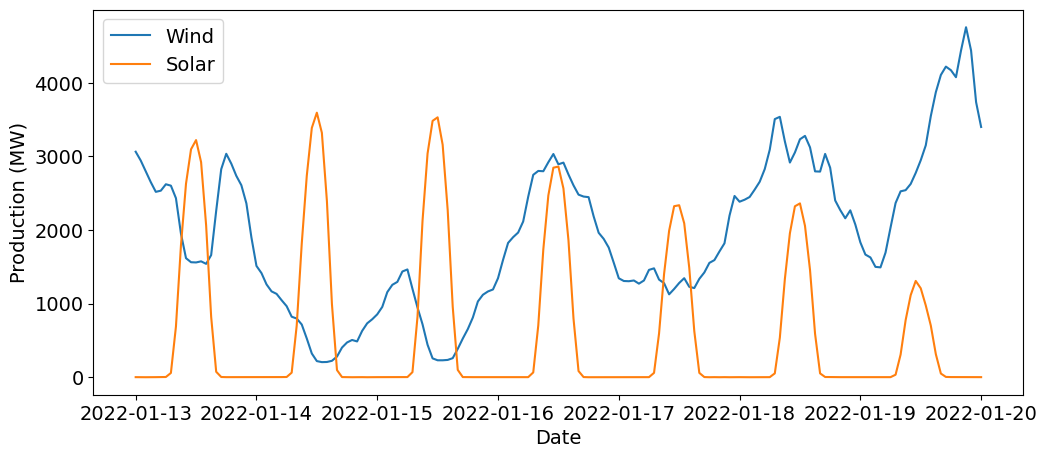

In [37]:
plt.rcParams.update({'font.size': 14})  # Set font size to 14
number_of_days = 7
start_date = "2022-01-13"
end_date = datetime.datetime.strptime(start_date, "%Y-%m-%d") + datetime.timedelta(days=number_of_days)
end_date = end_date.strftime("%Y-%m-%d")
df_plot = df[df["dt_iso"] >= start_date]
df_plot = df_plot[df_plot["dt_iso"] <= end_date]
plt.figure(figsize=(12, 5))
plt.plot(df_plot["dt_iso"], df_plot["production_wind"], label="Wind")
plt.plot(df_plot["dt_iso"], df_plot["production_solar"], label="Solar")
plt.xlabel("Date")
plt.ylabel("Production (MW)")
plt.legend()
plt.savefig(f"{output_path}/energy_production_sample_week.png")
plt.show()
plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})

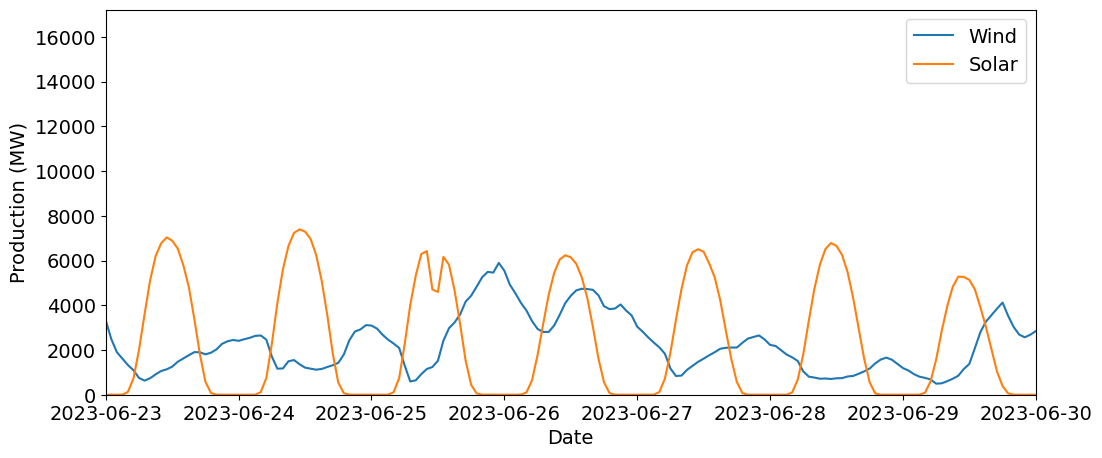

In [38]:
plt.rcParams.update({'font.size': 14})  # Set font size to 14
fig, ax = plt.subplots(figsize=(12, 5))
line1, = ax.plot([], [], label="Wind")
line2, = ax.plot([], [], label="Solar")
ax.legend()
ax.set_ylim(0, max(df["production_wind"].max(), df["production_solar"].max()))
ax.set_xlabel("Date")
ax.set_ylabel("Production (MW)")
def animate(i):
    start_date = df["dt_iso"].min() + datetime.timedelta(days=i)
    end_date = start_date + datetime.timedelta(days=number_of_days)
    df_plot = df[(df["dt_iso"] >= start_date) & (df["dt_iso"] <= end_date)]
    line1.set_data(df_plot["dt_iso"], df_plot["production_wind"])
    line2.set_data(df_plot["dt_iso"], df_plot["production_solar"])
    ax.set_xlim(start_date, end_date)
    return line1, line2

ani = animation.FuncAnimation(fig,
                              animate,
                              frames=int((df["dt_iso"].max() - df["dt_iso"].min()).days - number_of_days + 1),
                              interval=75,
                              blit=True)
ani.save(f"{output_path}/energy_production.mp4")
plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})

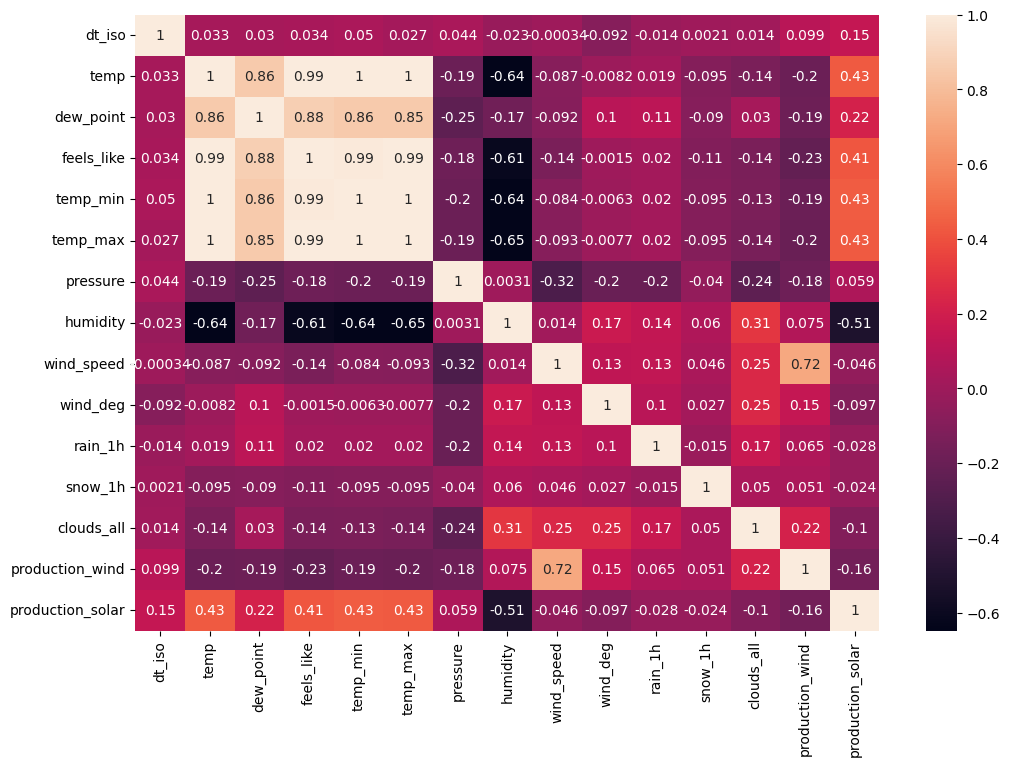

In [39]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.savefig(f"{output_path}/corr_all.png")
plt.show()

- The temp column perfectly correlates with temp_min and temp_max, therefore we can remove temp_min and temp_max without losing much information
- The feels like column also correlates very strongly with temp, so it can be removed as well
- The rain_1h and snow_1h columns have very small correlations (< 0.1) with either solar or wind production, so they can also be safely discarded
- pressure has a very small correlation with solar production, but has a not insignificant negative correlation with wind production, so we will keep it
- humidity has a very small correlation with wind production, but has a strong negative correlation with solar production, so it will be kept

In [40]:
df.drop(columns=["feels_like","temp_min", "temp_max", "rain_1h", "snow_1h"], inplace=True)
df.to_csv("./data/france_weather_energy_with_date.csv", index=False)

In [41]:
df.describe(include="all")

,dt_iso,temp,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all,production_wind,production_solar
count,25771,25771.000000,25771.000000,25771.000000,25771.000000,25771.000000,25771.000000,25771.000000,25771.000000,25771.000000
mean,2022-01-09 22:42:16.944627712+00:00,11.968124,7.744574,1018.079275,77.871600,3.091761,178.616313,63.785457,4519.053840,1100.242501
min,2020-07-22 00:00:00+00:00,-7.670000,-8.750000,980.000000,19.000000,0.030000,0.000000,0.000000,42.000000,0.000000
25%,2021-04-16 11:30:00+00:00,6.485000,3.600000,1014.000000,67.000000,1.960000,84.000000,27.000000,1832.000000,1.000000
50%,2022-01-09 23:00:00+00:00,11.650000,7.920000,1018.000000,82.000000,2.820000,200.000000,81.000000,3444.000000,40.000000
75%,2022-10-05 09:30:00+00:00,17.125000,12.370000,1023.000000,91.000000,3.940000,248.000000,99.000000,6362.000000,1958.000000
max,2023-06-30 21:00:00+00:00,37.600000,22.740000,1041.000000,100.000000,12.140000,360.000000,100.000000,17220.000000,10832.000000
std,NaN,7.601946,5.652810,7.899252,16.702389,1.560377,97.984908,38.530210,3491.703475,1597.283588


In [42]:
df = df.drop(columns=["dt_iso"]).reset_index(drop=True)

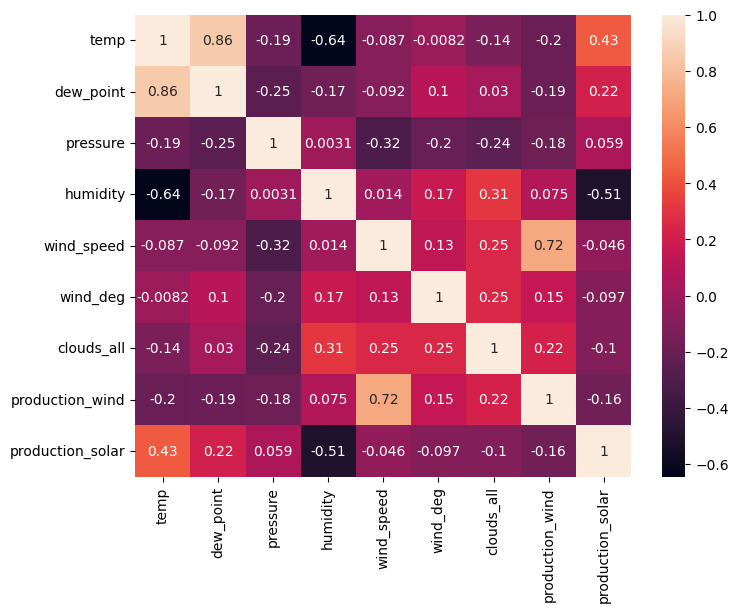

In [43]:
plt.figure(figsize=(8, 6))
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.savefig(f"{output_path}/corr_select.png")
plt.show()

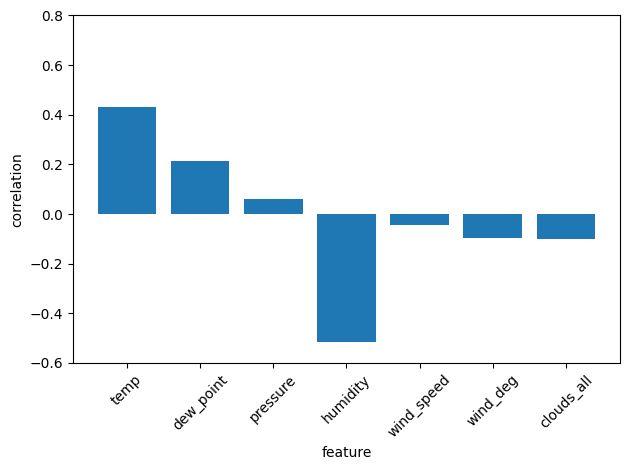

In [44]:
plt.bar(corr["production_solar"].index[:-2], corr["production_solar"].values[:-2])
plt.ylim(-0.6, 0.8)
plt.xticks(rotation=45)
plt.xlabel("feature")
plt.ylabel("correlation")
plt.tight_layout()
plt.savefig(f"{output_path}/corr_solar.png")
plt.show()

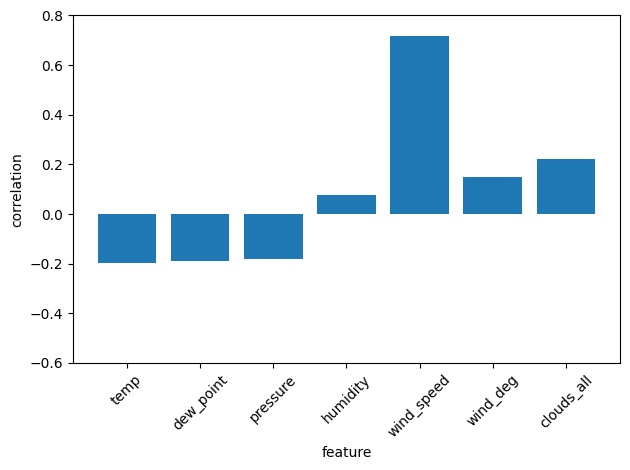

In [45]:
plt.bar(corr["production_wind"].index[:-2], corr["production_wind"].values[:-2])
plt.ylim(-0.6, 0.8)
plt.xticks(rotation=45)
plt.xlabel("feature")
plt.ylabel("correlation")
plt.tight_layout()
plt.savefig(f"{output_path}/corr_wind.png")
plt.show()

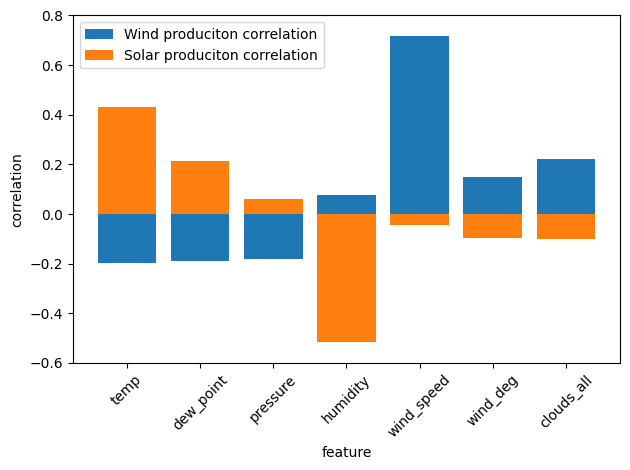

In [46]:
plt.bar(corr["production_wind"].index[:-2], corr["production_wind"].values[:-2], label="Wind produciton correlation")
plt.bar(corr["production_solar"].index[:-2], corr["production_solar"].values[:-2], label="Solar produciton correlation")
plt.ylim(-0.6, 0.8)
plt.xticks(rotation=45)
plt.xlabel("feature")
plt.ylabel("correlation")
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_path}/corr_solar_wind.png")
plt.show()

In [47]:
df.to_csv("./data/france_weather_energy.csv", index=False)